In [ ]:
!pip install lazypredict

In [1]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
alldata = pd.read_csv(r".\data\AF50m_subset_REGEX_man_labels_5k.txt", sep="\t")


In [3]:
#pre processing
print(f"NA in data:\n{alldata.isna().sum()}")

print("\n\ncleaning...\n\n")

# note has many NAs and we don't use it so removing 
data_clean_tmp = alldata.drop(columns=["note"])

data_clean_tmp.isna().sum()

# there are still some NA values, removing them
data_clean_tmp = data_clean_tmp.dropna()


### check values
print(f"regex label value counts \n{data_clean_tmp["regex_label"].value_counts()}\n")

print(f"manural label value coutns \n{data_clean_tmp["manual_label"].value_counts()}\n")

# the label on the manual_label is "low" while on "regex_label" it is "low informative", lets make it consistent 
data_clean_tmp["regex_label"] = data_clean_tmp["regex_label"].replace("low informative", "low")

data_clean = data_clean_tmp


### check values
print(f"regex label value counts \n{data_clean["regex_label"].value_counts()}\n")

print(f"manural label value coutns \n{data_clean["manual_label"].value_counts()}\n")



NA in data:
protein_annotation        2
regex_label               2
manual_label          17103
note                  21998
dtype: int64


cleaning...


regex label value counts 
regex_label
proper             4674
uninformative       189
low informative     137
Name: count, dtype: int64

manural label value coutns 
manual_label
proper           4371
uninformative     437
low               192
Name: count, dtype: int64

regex label value counts 
regex_label
proper           4674
uninformative     189
low               137
Name: count, dtype: int64

manural label value coutns 
manual_label
proper           4371
uninformative     437
low               192
Name: count, dtype: int64



In [4]:
X = data_clean["protein_annotation"]
y = data_clean["manual_label"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
XY_full = data_clean[["protein_annotation", "manual_label"]]
XY_full.rename(columns={"protein_annotation" : "X", "manual_label": "y"}, inplace=True)

XY_predictions_regex = data_clean[["protein_annotation", "regex_label"]]
XY_predictions_regex.rename(columns={"protein_annotation" : "X", "regex_label": "y"}, inplace=True)

In [6]:
# little DE
XY_full["y"].value_counts()

len(XY_full)


5000

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from typing import Protocol, runtime_checkable


class ModelReport(object):
    def __init__(self):

        self.metrics = None
        
        # confusion matrix and its displat labels 
        self.cm = None
        self.cm_display_labels = None

    def show_report(self):
        print(self.metrics)
        
        # create confustion matrix and display it
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, 
                                         display_labels=self.cm_display_labels)
        cm_disp.plot()


class ModelEvaluator(object):
    def __init__(self, model, eval_dataset):
        """Create model evaluators 

        Args:
            model (ModelEvalWrapper): model to evaluate
            eval_dataset (Dataframe): dataset to evaluate on, should have X and y 
        """
        assert isinstance(model, ModelEvalWrapper), "Model must be of a ModelEvalWrapper class"
        self.model = model
        self.eval_dataset = eval_dataset

    def _predict(self): 
        return self.model.model.predict(self.eval_dataset["X"])

    def generate_report(self):
        y_true = self.eval_dataset["y"]
        y_pred = self._predict()
        
        report = ModelReport()     
#        report.metrics = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)
        report.metrics = classification_report(y_true=y_true, y_pred=y_pred)

        # confustion matrix
        report.cm_display_labels = unique_labels(y_true, y_pred)
        report.cm = confusion_matrix(y_true,y_pred)
        return report
    

@runtime_checkable
class ModelEvalWrapperInterface(Protocol):
    """
    An interface for the model evaluator. 
    Implementing this interface is required for evaluating the model using ModelEvaluator
    """
    def predict(X):
        """
        :param X: a dataframe with X to prredict
        :returns the predictions as a dataframe
        """
        pass


class ModelEvalWrapper(object):
    """
    Wrapping the pretrained model to send for evaluation
    """
    def __init__(self, model, title):
        """
        :param model: Model to evaluate, the model should be already trained and implement the methods in  
        :param title: Title or label for this evaluation instance
        """
        assert isinstance(model, ModelEvalWrapperInterface), "model must implement the ModelEvalWrapperInterface Protocol"
        self.model = model
        self.title = title



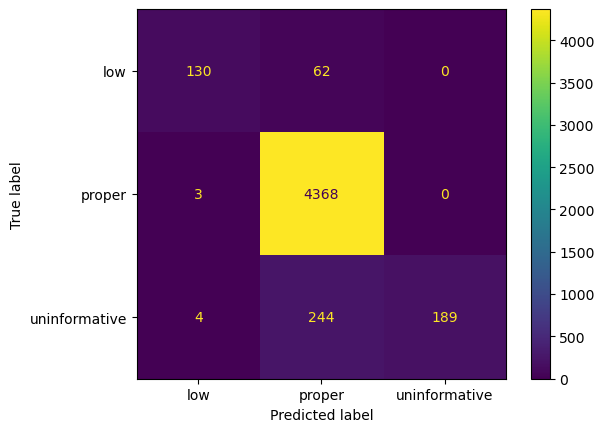

In [15]:
# import importlib
# from models.regex import RegexModel

# regex_m = RegexModel()
# # regex_m.predict(["Unknown function", " ", "Not known", "no data", "\n"])

cm_display_labels = unique_labels(y_true, y_pred)
cm = confusion_matrix(y_true,y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, 
                                         display_labels=cm_display_labels).plot()

               precision    recall  f1-score   support

          low       0.95      0.68      0.79       192
       proper       0.93      1.00      0.97      4371
uninformative       1.00      0.43      0.60       437

     accuracy                           0.94      5000
    macro avg       0.96      0.70      0.79      5000
 weighted avg       0.94      0.94      0.93      5000



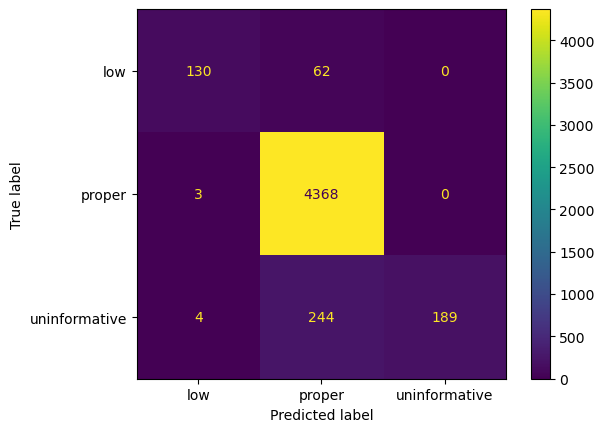

In [11]:
y_true = XY_full["y"]
y_pred = XY_predictions_regex["y"]

m = ModelEvaluator(ModelEvalWrapper(regex_m, "regex"), XY_full)
c_report = m.generate_report()
c_report.show_report()



In [42]:
import evalml
from evalml import ModelEvaluator

evaluator = ModelEvaluator(problem_type='binary')
evaluator.evaluate_predictions(y_true=df['actual'], y_pred=df['pred'])


ModuleNotFoundError: No module named 'evalml'

In [121]:
!pip install evalml

     ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
     ------------- -------------------------- 1.8/5.3 MB 10.1 MB/s eta 0:00:01
     ------------------------------- -------- 4.2/5.3 MB 11.0 MB/s eta 0:00:01
     ---------------------------------------- 5.3/5.3 MB 8.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: still running...
  Getting requirements to build wheel: still running...
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/6.6 MB ? eta -:--:--
   ----------- ---------------------------- 1.8/6.6 MB 9.1 MB/s eta 0:00:01
   -

  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [2575 lines of output]
      <string>:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
      C:\Users\Elon\AppData\Local\Temp\pip-build-env-39b67zfl\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and 

In [44]:
%debug

> c:\users\elon\anaconda3\envs\main\lib\site-packages\numpy\lib\arraysetops.py(336)_unique1d()
    334         aux = ar[perm]
    335     else:
--> 336         ar.sort()
    337         aux = ar
    338     mask = np.empty(aux.shape, dtype=np.bool_)

    331 
    332     if optional_indices:
    333         perm = ar.argsort(kind='mergesort' if return_index else 'quicksort')
    334         aux = ar[perm]
    335     else:
--> 336         ar.sort()
    337         aux = ar
    338     mask = np.empty(aux.shape, dtype=np.bool_)
    339     mask[:1] = True
    340     if (equal_nan and aux.shape[0] > 0 and aux.dtype.kind in "cfmM" and
    341             np.isnan(aux[-1])):

ar = array(['proper', nan, nan, ..., nan, nan, nan], dtype=object)
return_index = False
return_inverse = False
return_counts = False
equal_nan = True
